In [1]:
import torch
print(f"Can work with GPU?: {torch.cuda.is_available()}")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from IPython.display import clear_output
from bs4 import BeautifulSoup
from segment_anything import sam_model_registry, SamPredictor

Can work with GPU?: True


In [ ]:
"""
1. Load in the images
2. Load in the annotations
3. Use this as the prompt for the SAM
4. Run SAM with top 3
5. Store all 3 masks
6. Pick best masks and store

Dataset -> SAM segmented -> Data augmented (in process of model) -> Model training

Pipeline:
Image upload -> click on point for SAM segmentation -> predict model -> return probabilities
"""

### Load in Annotations

In [74]:
species = "snoek"
image_n = images[0]

### Helper Functions

In [75]:
def get_image_data(species, image):
    file_path = f"dataset/dataset_new/{species}/{image['name']}"
    x,y = image.select("points")[0]['points'].split(",")
    x,y = int(float(x)), int(float(y))
    return file_path, x,y

def show_mask(mask, ax):
    color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

In [3]:
device = 'cuda'
print(torch.__version__, torch.version.cuda, torch.backends.cudnn.version())

1.13.1+cu117
11.7
8500


### Setup SAM

In [8]:
sam = sam_model_registry["default"](checkpoint="./sam_vit_h_4b8939.pth")

In [9]:
sam.to(device='cuda');

In [10]:
predictor = SamPredictor(sam)

# Pipeline
- Load in image with annotation
- Load into SAM
- Use annotation for SAM prompt
- Return mask
- Combine mask with image for new image
- Store this image

In [94]:
species = "baars"

with open(f'{species}.xml', 'r') as f:
    data = f.read()

# the beautifulsoup parser, storing
# the returned object 
soup = BeautifulSoup(data, "xml")

images = soup.select("image")

In [95]:
image_n = images[0]

def get_image_data(species, image):
    file_path = f"dataset/dataset_new/{species}/{image['name']}"
    x,y = image.select("points")[0]['points'].split(",")
    x,y = int(float(x)), int(float(y))
    return file_path, x,y

In [96]:
output_path = f"sam_dataset/images/{species}"

dataset/dataset_new/baars/baars9.jpg


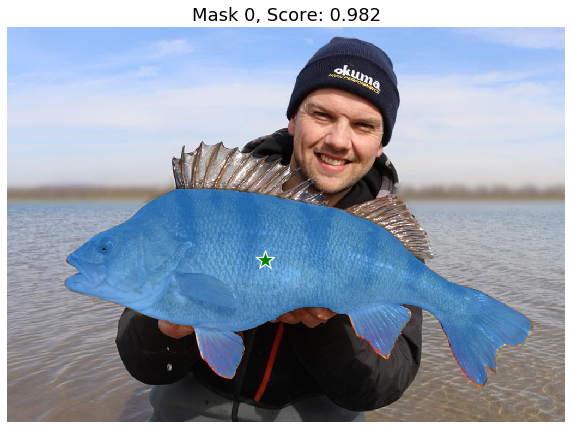

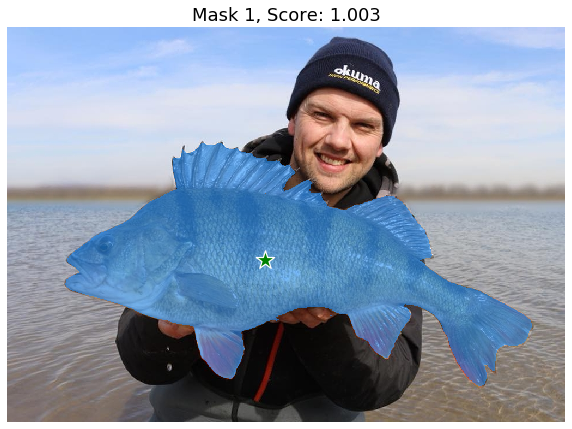

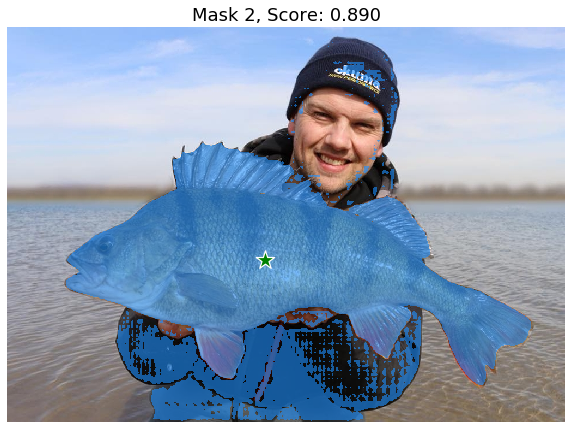

What is the best mask (0-2):  1


In [97]:
for elem in images:
    file_path, x,y = get_image_data(species, elem)
    print(file_path)
    image = cv2.imread(file_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    predictor.set_image(image)
    
    input_point = np.array([[x,y]])
    input_label = np.array([1])
    
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )
    
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10,10))
        plt.imshow(image)
        show_mask(mask, plt.gca())
        show_points(input_point, input_label, plt.gca())
        plt.title(f"Mask {i}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()  
    
    correct_mask = input("What is the best mask (0-2): ")
    
    if correct_mask not in ["0", "1", "2"]:
        correct_mask = input("What is the best mask (0-2): ")
    
    y=np.expand_dims(masks[int(correct_mask)],axis=2)
    newmask=np.concatenate((y,y,y),axis=2)
    cob= image * newmask
    
    im = Image.fromarray(cob)
    im.save(f"{output_path}/sam_{elem['name']}")
    clear_output(wait=True)
    
    